In [1]:
#DropletUtils:package for reading in and removing empty droplets
library(DropletUtils)
#scds:package for removing doublets
library(scds)
#feather: package for effiecient writing of data frame objects
library(feather)
#Matrix: package for dealing with sparse data
library(Matrix)


Loading required package: BiocParallel

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Positi

In [2]:
#read in srna-seq matrix files, these folders should have a barcodes.tsv, genes.tsv, and matrix.mtx files
#For a star-solo based alignment we read in the lanes seperately and the combine them
#For Cell Ranger based alignment we can just read in the filtered matrices
caudate_1 <- read10xCounts("../data/raw/caudate/L1/Solo.out/")
caudate_2 <- read10xCounts("../data/raw/caudate/L2/Solo.out/")
caudate_3 <- read10xCounts("../data/raw/caudate/L3/Solo.out/")
caudate_4 <- read10xCounts("../data/raw/caudate/L4/Solo.out/")


In [3]:
#combine lanes for the caudate, you ran cell ranger
caudate_all <- counts(caudate_1)+counts(caudate_2)+counts(caudate_3)+counts(caudate_4)


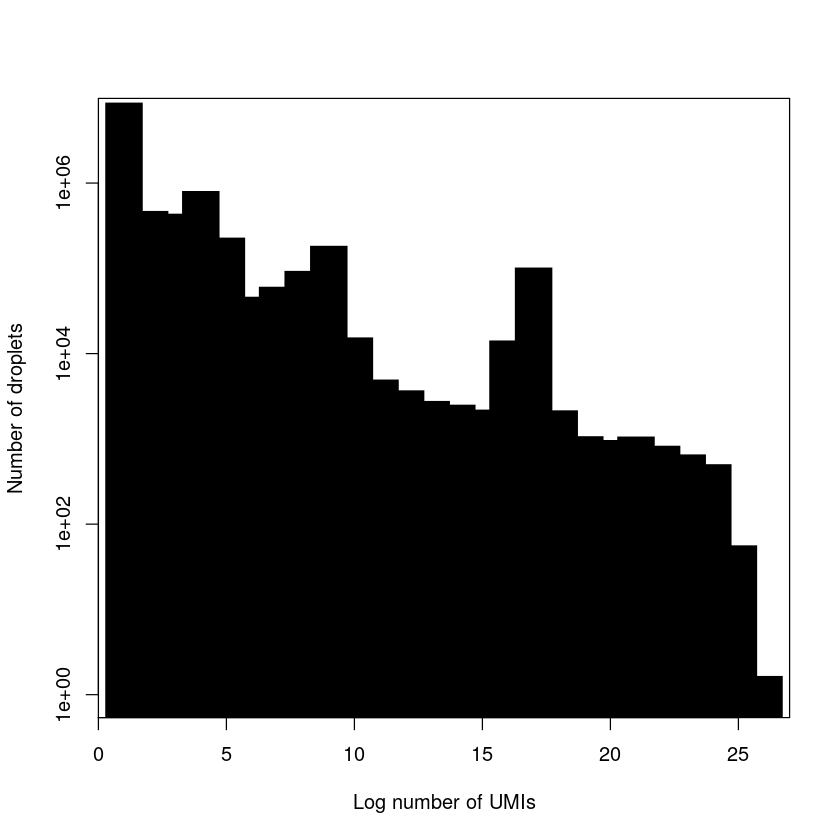

In [4]:
#plot number of umis per droplet
#add pseudocount of 1 for log transform
caudate_raw_umi_droplet_counts = colSums(caudate_all)+1
caudate_raw_droplet_umi_hist = hist(log(caudate_raw_umi_droplet_counts),plot=FALSE,breaks=20) 
plot(caudate_raw_droplet_umi_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of UMIs",ylab="Number of droplets")


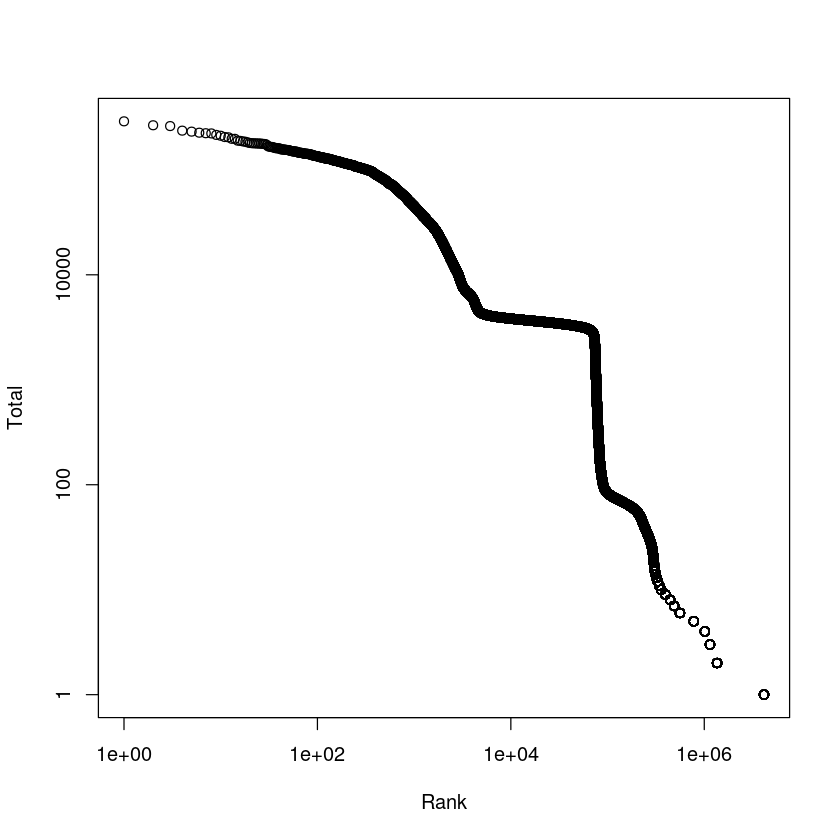

In [5]:
#plotting number of umis vs the rank
caudate_br_out = barcodeRanks(caudate_all)
plot(caudate_br_out$rank, caudate_br_out$total+1, log="xy", xlab="Rank", ylab="Total")



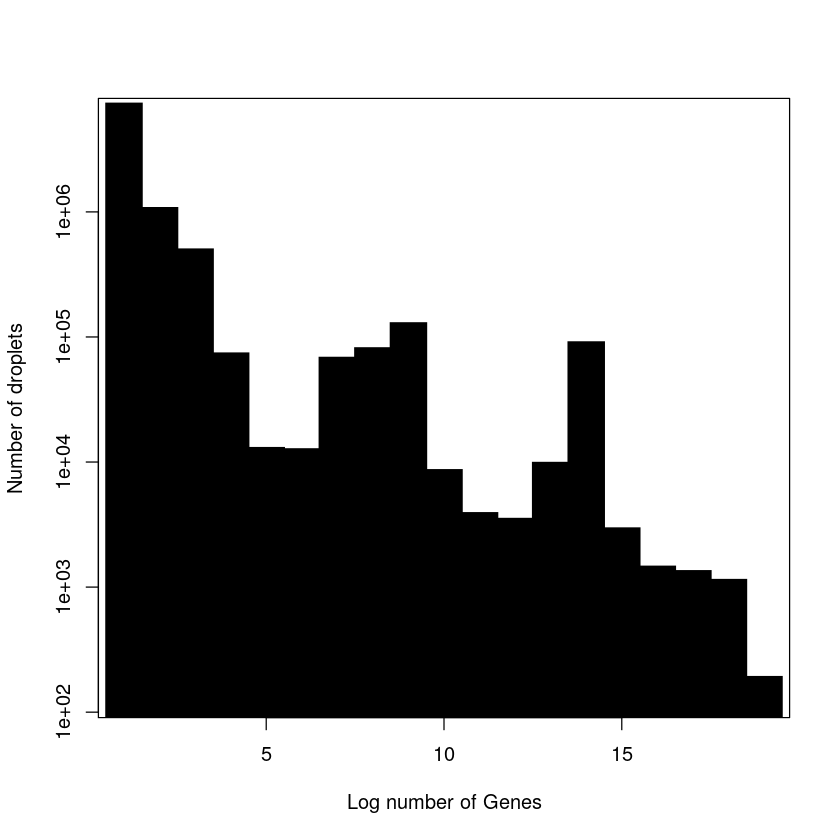

In [6]:
#plot number of umis per droplet
#binarizing the matrix with >0 turns UMI counts into gene counts
caudate_raw_gene_droplet_counts = colSums(caudate_all>0)+1
caudate_raw_droplet_gene_hist = hist(log(caudate_raw_gene_droplet_counts),plot=FALSE,breaks=20) 
plot(caudate_raw_droplet_gene_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of Genes",ylab="Number of droplets")

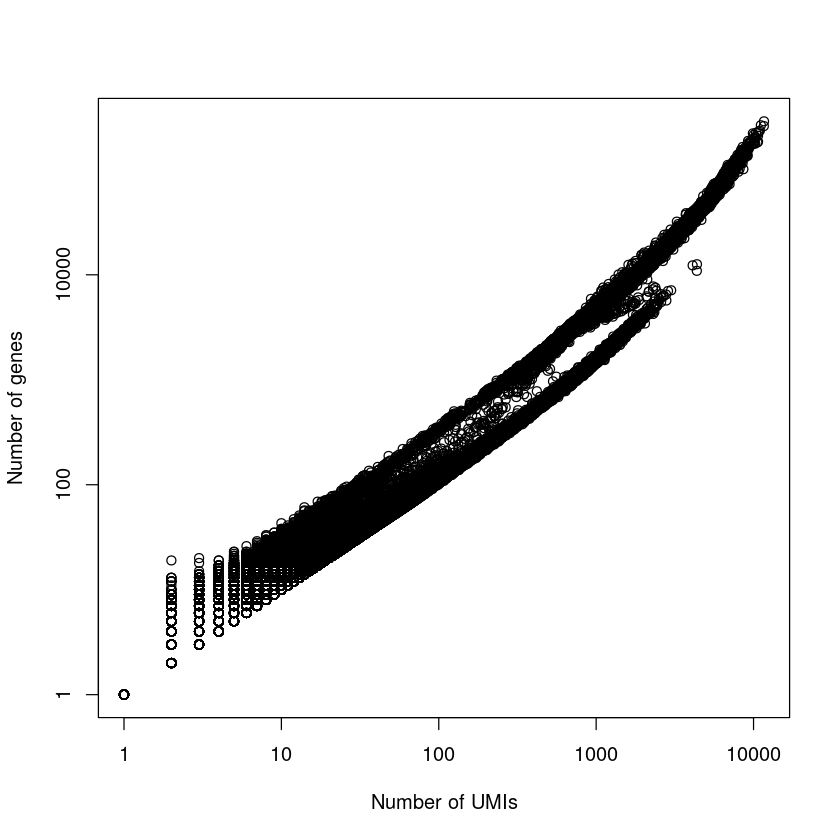

In [7]:
#plotting number of UMIs vs number of genes
plot(caudate_raw_umi_droplet_counts~caudate_raw_gene_droplet_counts,log="xy",xlab="Number of UMIs",ylab="Number of genes")

In [8]:
#predict which droplets are empty, the defaultdrops functin replciates the same task in cell ranger
caudate_called <- defaultDrops(caudate_all)

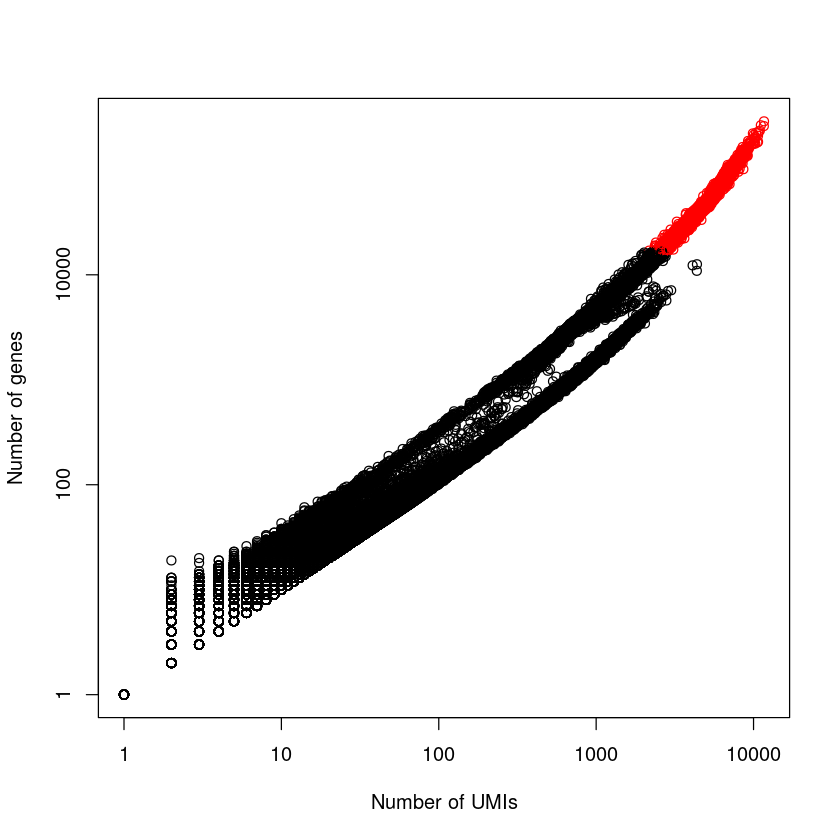

In [9]:
#plot which droplets got picked as cells
plot(caudate_raw_umi_droplet_counts~caudate_raw_gene_droplet_counts,col=ifelse(caudate_called,"red","black"),log="xy",xlab="Number of UMIs",ylab="Number of genes")

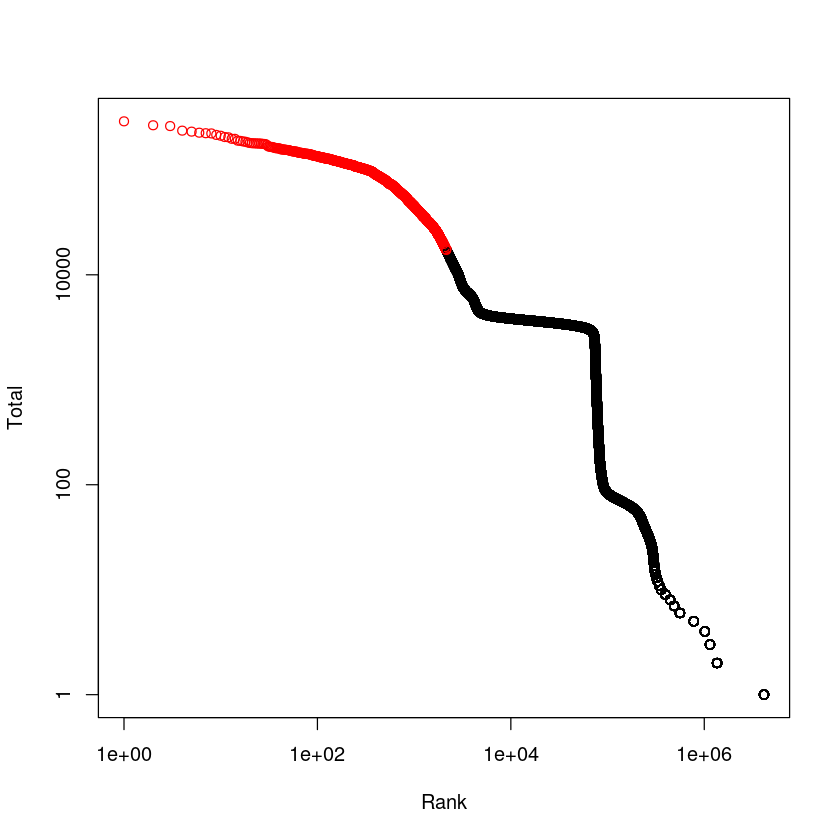

In [10]:
#plot which droplets got picked as cells in the rank plot
plot(caudate_br_out$rank, caudate_br_out$total+1, col=ifelse(caudate_called,"red","black"),log="xy", xlab="Rank", ylab="Total")


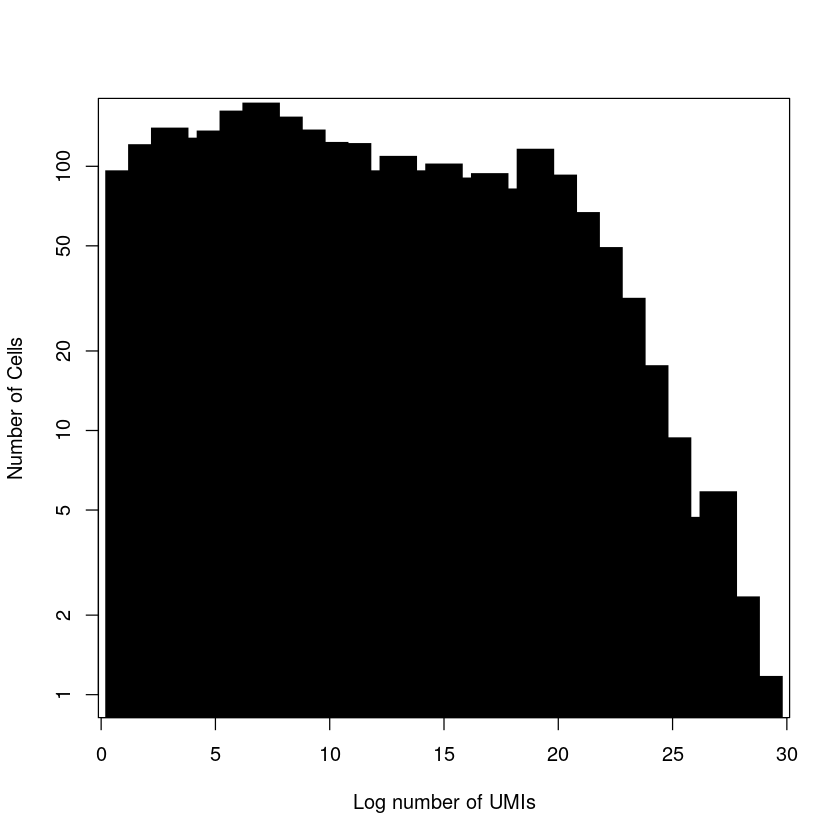

In [11]:
#plot number of umis per cell
caudate_called_droplet_umi_hist = hist(log(caudate_raw_umi_droplet_counts[caudate_called]),plot=FALSE,breaks=30) 
plot(caudate_called_droplet_umi_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of UMIs",ylab="Number of Cells")


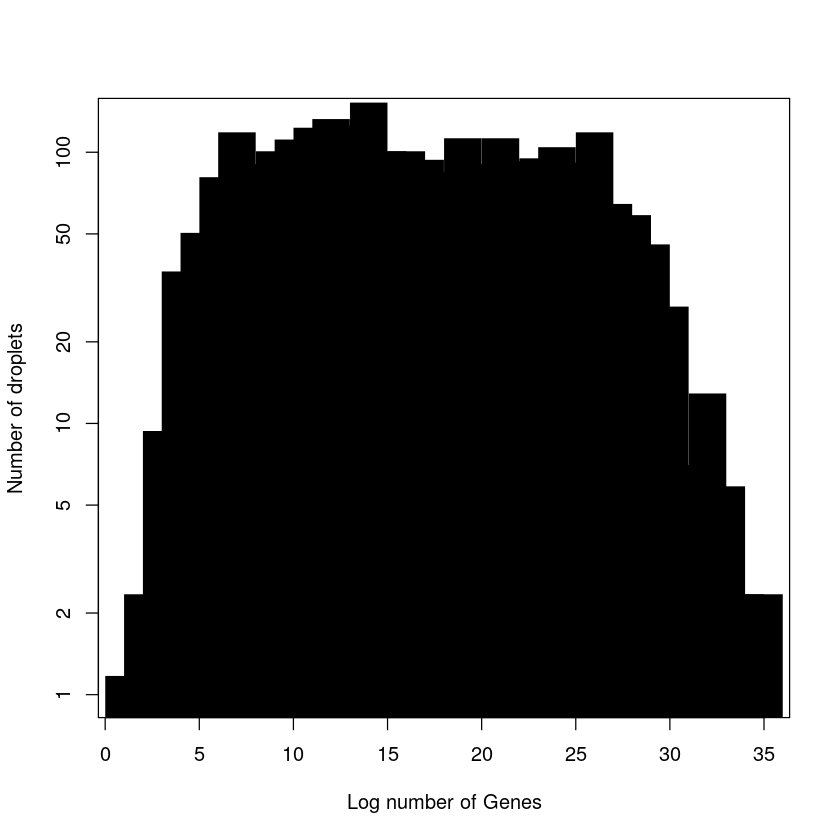

In [12]:
#plot number of genes per droplet
caudate_raw_droplet_gene_hist = hist(log(caudate_raw_gene_droplet_counts[caudate_called]),plot=FALSE,breaks=30) 
plot(caudate_raw_droplet_gene_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of Genes",ylab="Number of droplets")

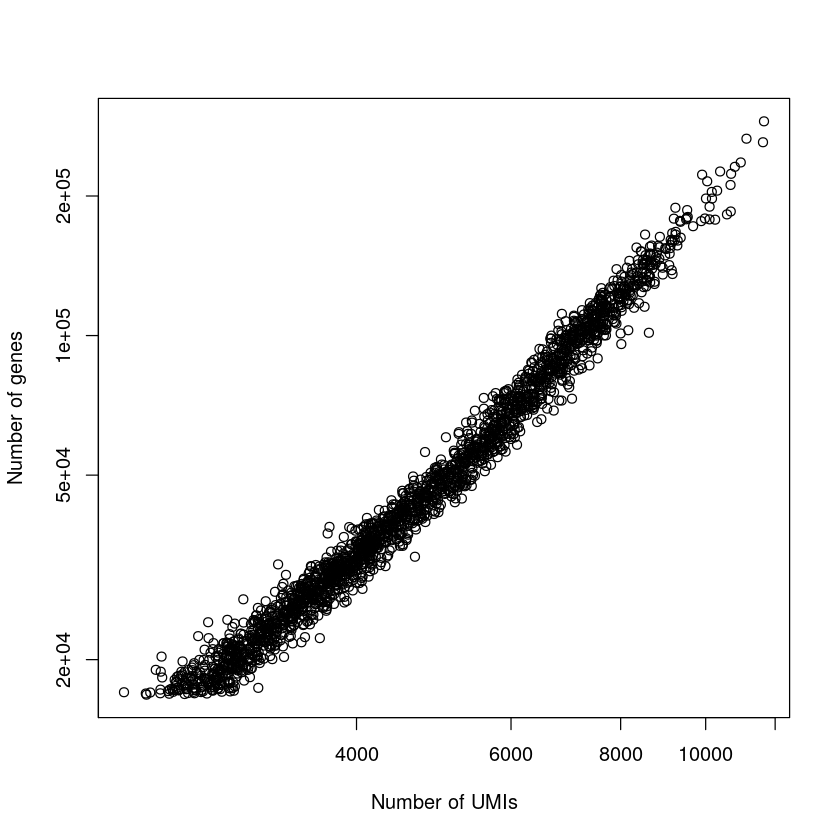

In [13]:
#plotting number of UMIs vs number of genes for called cells
plot(caudate_raw_umi_droplet_counts[caudate_called]~caudate_raw_gene_droplet_counts[caudate_called],log="xy",xlab="Number of UMIs",ylab="Number of genes")

In [14]:
#remove empty droplets and create a SingleCellExperiment object
caudate_cells <- caudate_all[, caudate_called]
sce_caudate <- SingleCellExperiment(list(counts=caudate_cells))
rowData(sce_caudate) = rowData(caudate_1)

In [15]:
#use the scds package to remove doublets
sce_caudate <- cxds_bcds_hybrid(sce_caudate,list("retRes"=TRUE))


[1]	train-error:0.093664+0.005420	test-error:0.138178+0.014371 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 2 rounds.

[2]	train-error:0.079915+0.004598	test-error:0.115034+0.007855 
[3]	train-error:0.066453+0.002438	test-error:0.106789+0.005308 
[4]	train-error:0.061984+0.000816	test-error:0.104948+0.004760 
[5]	train-error:0.057631+0.001115	test-error:0.097382+0.005055 
[6]	train-error:0.053677+0.001677	test-error:0.097385+0.004965 
[7]	train-error:0.050927+0.001988	test-error:0.094631+0.005965 
[8]	train-error:0.048579+0.001651	test-error:0.092797+0.006560 
[9]	train-error:0.045199+0.001752	test-error:0.092343+0.003652 
[10]	train-error:0.042049+0.000994	test-error:0.091424+0.006240 
[11]	train-error:0.040044+0.000910	test-error:0.091883+0.004564 
[12]	train-error:0.038324+0.001508	test-error:0.090970+0.006610 
[13]	train-error:0.035575+0.000998	test-error:0.087306+0.004442 
[14]	train-error:0.031565+0.001

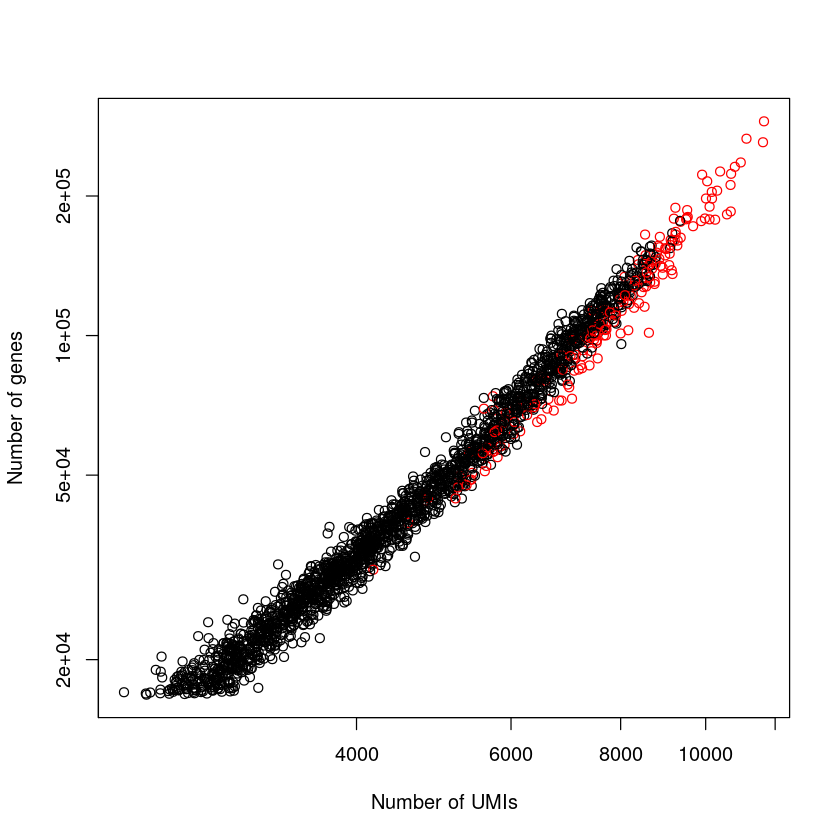

In [16]:
#selected doublets should have higher number of UMIs and genes
plot(caudate_raw_umi_droplet_counts[caudate_called]~caudate_raw_gene_droplet_counts[caudate_called],col=ifelse(sce_caudate$hybrid_score>1.0,"red","black"),log="xy",xlab="Number of UMIs",ylab="Number of genes")

In [17]:
#create annoation matrix for caudate and write to file
caudate_annotation =  data.frame("cell_id"=caudate_1@colData@listData$Barcode[caudate_called],
                                 "nUMIs"=caudate_raw_umi_droplet_counts[caudate_called]-1,
                                 "nGenes"=caudate_raw_gene_droplet_counts[caudate_called]-1,
                                 "doublet_score"=colData(sce_caudate)$hybrid_score)
caudate_annotation$region = rep("caudate",nrow(caudate_annotation))

caudate_annotation_file = "../data/processed/caudate_cells_annotation.csv"
write.csv(caudate_annotation,caudate_annotation_file)

In [18]:
#write caudate cells expression matrix to file 
caudate_df = as.data.frame(as.matrix(caudate_cells))
colnames(caudate_df)<- caudate_1@colData@listData$Barcode[caudate_called]
caudate_path = "../data/processed/caudate_cells.feather"
write_feather(caudate_df,caudate_path)

In [19]:
#now we repeat the same process with the putamen
#read in srna-seq matrix files, these folders should have a barcodes.tsv, genes.tsv, and matrix.mtx files
#For a star-solo based alignment we read in the lanes seperately and the combine them
#For Cell Ranger based alignment we can just read in the filtered matrices
putamen_1 <- read10xCounts("../data/raw/putamen/L1/Solo.out/")
putamen_2 <- read10xCounts("../data/raw/putamen/L2/Solo.out/")
putamen_3 <- read10xCounts("../data/raw/putamen/L3/Solo.out/")
putamen_4 <- read10xCounts("../data/raw/putamen/L4/Solo.out/")


In [20]:
#combine lanes for the putamen, you ran cell ranger
putamen_all <- counts(putamen_1)+counts(putamen_2)+counts(putamen_3)+counts(putamen_4)

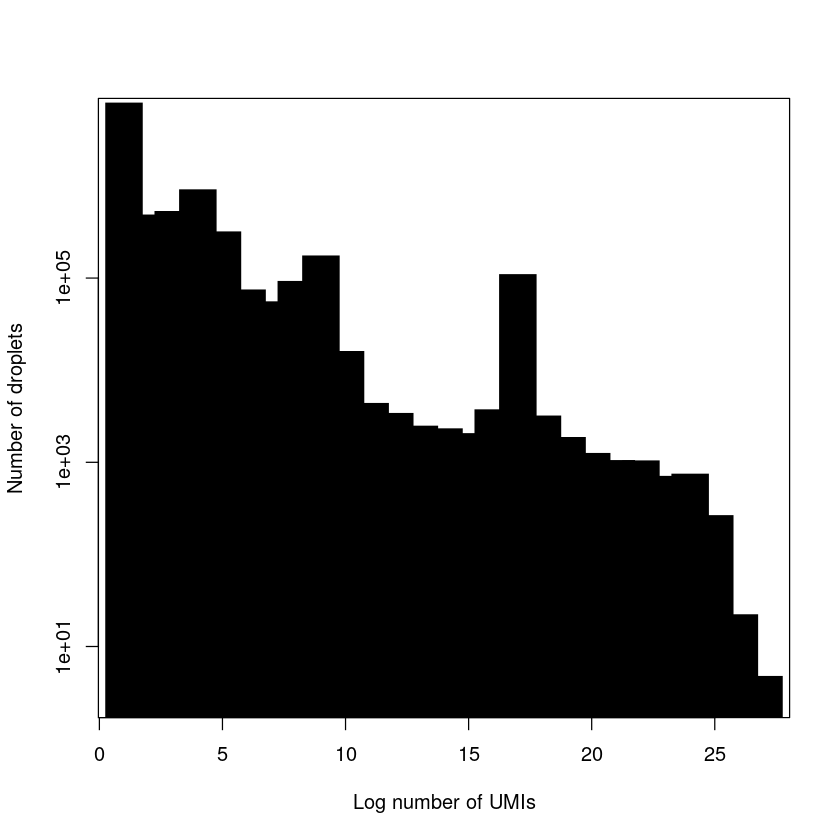

In [21]:
#plot number of umis per droplet
#add pseudocount of 1 for log transform
putamen_raw_umi_droplet_counts = colSums(putamen_all)+1
putamen_raw_droplet_umi_hist = hist(log(putamen_raw_umi_droplet_counts),plot=FALSE,breaks=20) 
plot(putamen_raw_droplet_umi_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of UMIs",ylab="Number of droplets")


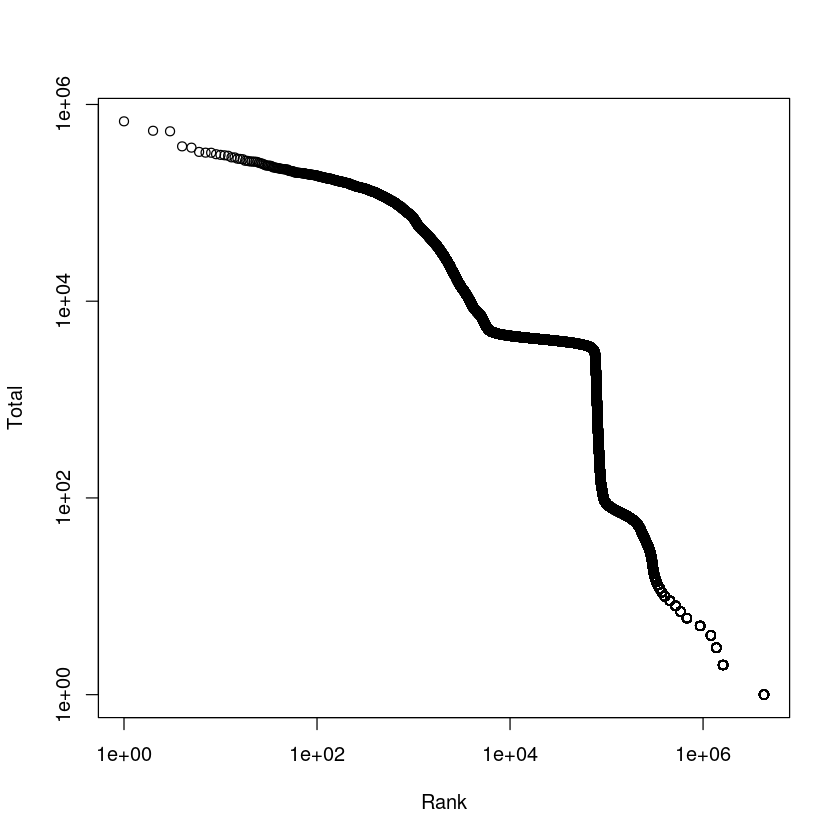

In [22]:
#plotting number of umis vs the rank
putamen_br_out = barcodeRanks(putamen_all)
plot(putamen_br_out$rank, putamen_br_out$total+1, log="xy", xlab="Rank", ylab="Total")

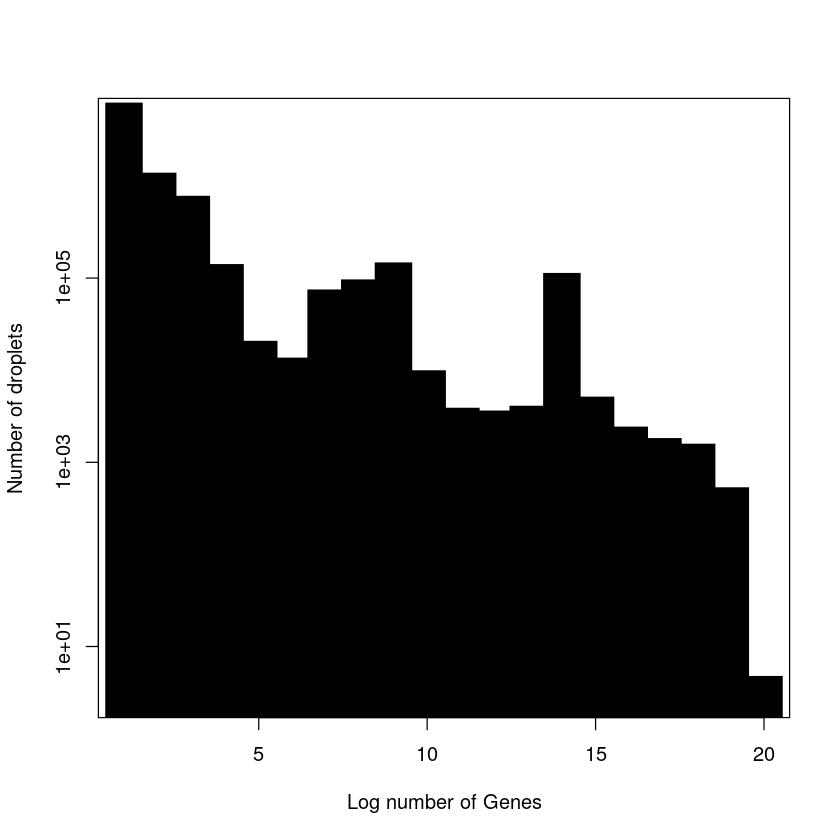

In [23]:
#plot number of umis per droplet
#binarizing the matrix with >0 turns UMI counts into gene counts
putamen_raw_gene_droplet_counts = colSums(putamen_all>0)+1
putamen_raw_droplet_gene_hist = hist(log(putamen_raw_gene_droplet_counts),plot=FALSE,breaks=20) 
plot(putamen_raw_droplet_gene_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of Genes",ylab="Number of droplets")

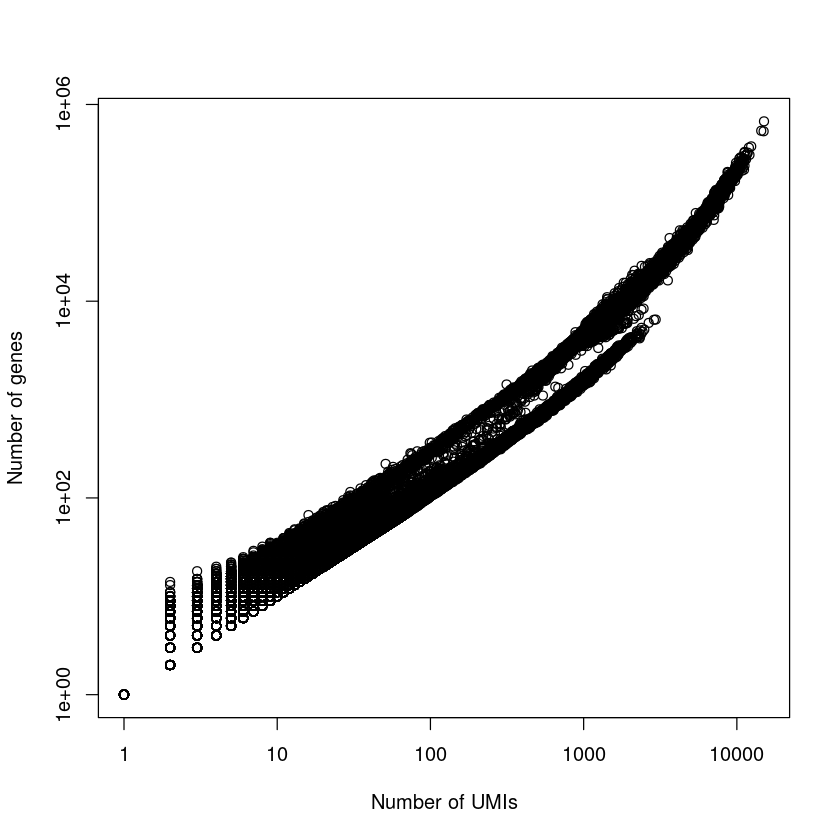

In [24]:
#plotting number of UMIs vs number of genes
plot(putamen_raw_umi_droplet_counts~putamen_raw_gene_droplet_counts,log="xy",xlab="Number of UMIs",ylab="Number of genes")


In [25]:
#predict which droplets are empty, the defaultdrops functin replciates the same task in cell ranger
putamen_called <- defaultDrops(putamen_all)


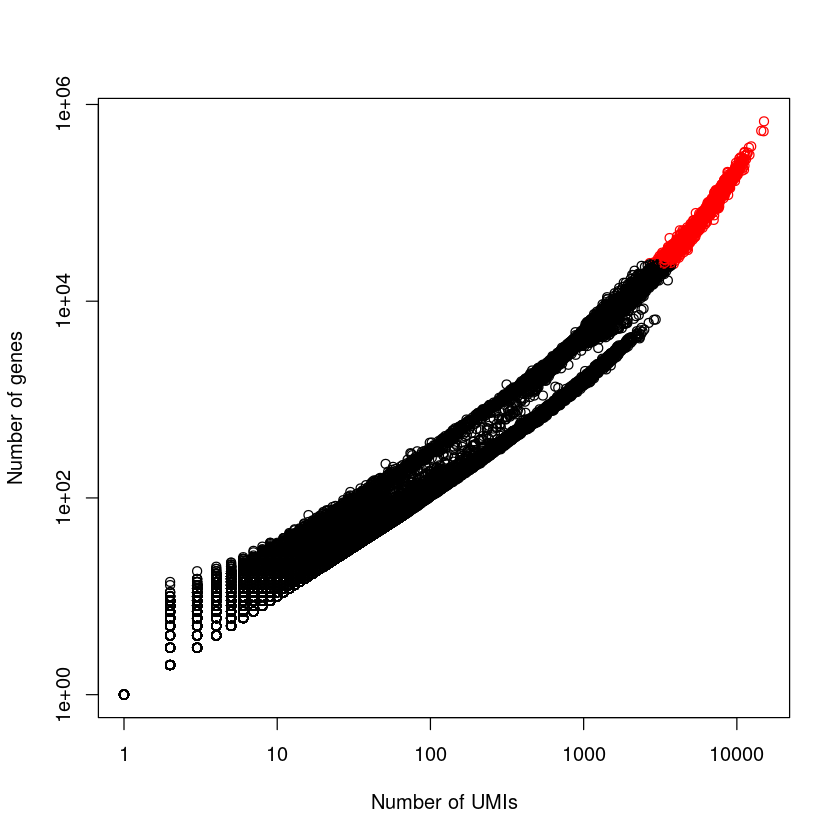

In [26]:
#plot which droplets got picked as cells
plot(putamen_raw_umi_droplet_counts~putamen_raw_gene_droplet_counts,col=ifelse(putamen_called,"red","black"),log="xy",xlab="Number of UMIs",ylab="Number of genes")

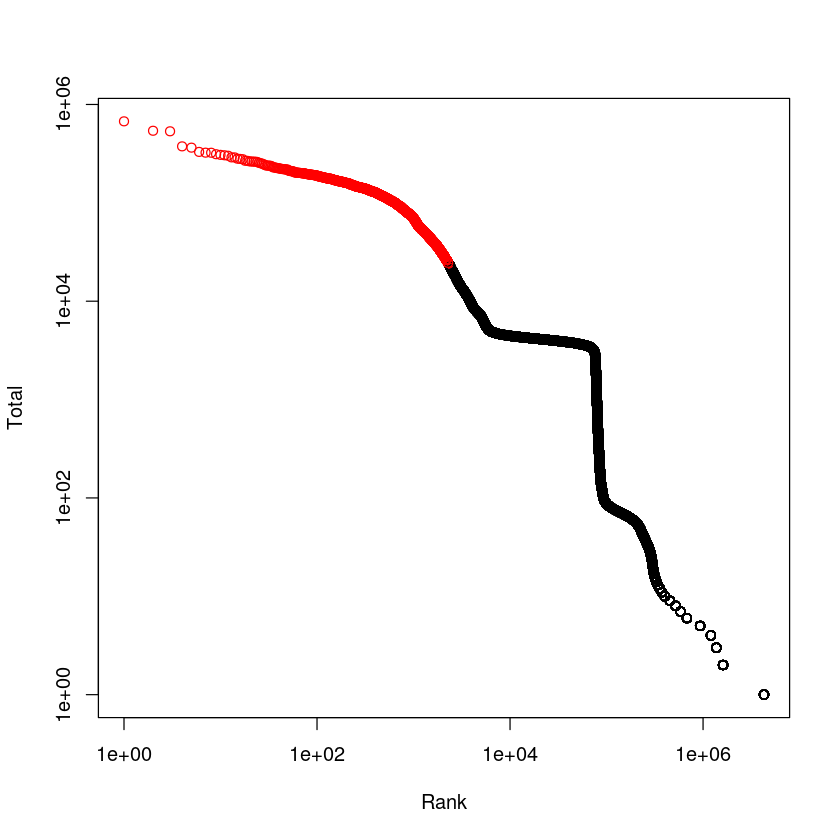

In [27]:
#plot which droplets got picked as cells in the rank plot
plot(putamen_br_out$rank, putamen_br_out$total+1, col=ifelse(putamen_called,"red","black"),log="xy", xlab="Rank", ylab="Total")

Warning message in xy.coords(x, y, xlabel, ylabel, log):
“3 y values <= 0 omitted from logarithmic plot”


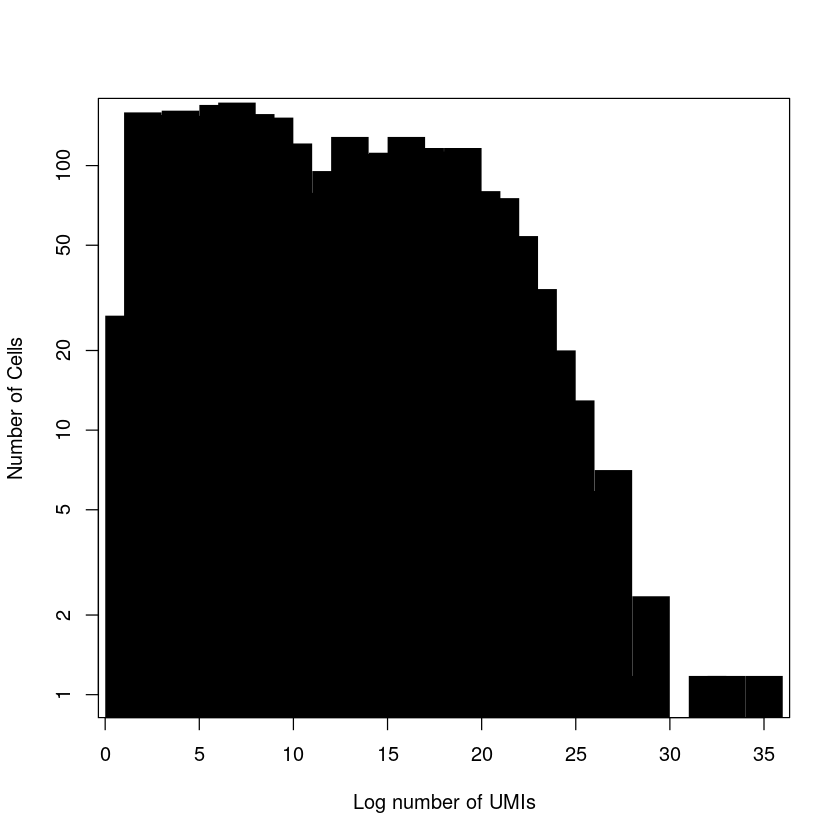

In [28]:
#plot number of umis per cell
putamen_called_droplet_umi_hist = hist(log(putamen_raw_umi_droplet_counts[putamen_called]),plot=FALSE,breaks=30) 
plot(putamen_called_droplet_umi_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of UMIs",ylab="Number of Cells")


Warning message in xy.coords(x, y, xlabel, ylabel, log):
“2 y values <= 0 omitted from logarithmic plot”


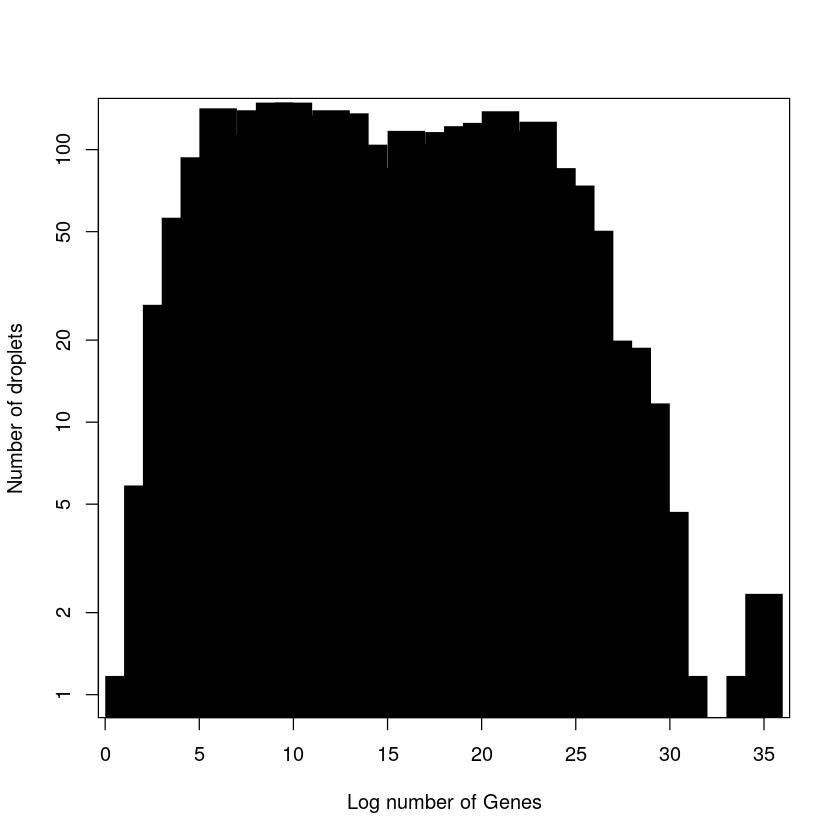

In [29]:
#plot number of genes per droplet
putamen_raw_droplet_gene_hist = hist(log(putamen_raw_gene_droplet_counts[putamen_called]),plot=FALSE,breaks=30) 
plot(putamen_raw_droplet_gene_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of Genes",ylab="Number of droplets")

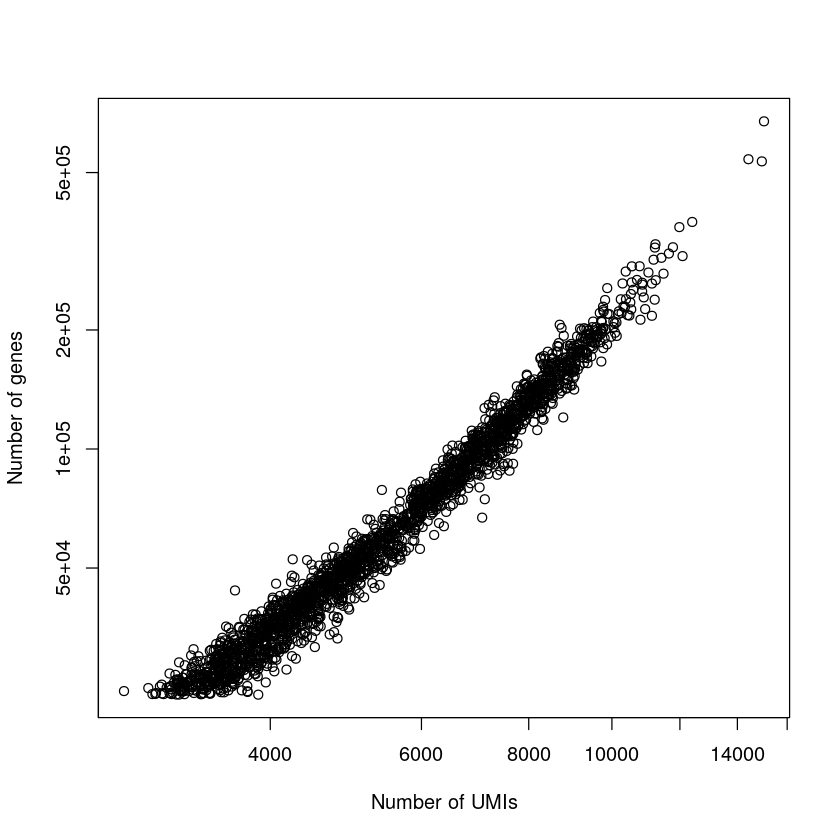

In [30]:
#plotting number of UMIs vs number of genes for called cells
plot(putamen_raw_umi_droplet_counts[putamen_called]~putamen_raw_gene_droplet_counts[putamen_called],log="xy",xlab="Number of UMIs",ylab="Number of genes")

In [31]:
#remove empty droplets and create a SingleCellExperiment object
putamen_cells <- putamen_all[, putamen_called]
sce_putamen <- SingleCellExperiment(list(counts=putamen_cells))
rowData(sce_putamen) = rowData(putamen_1)

In [34]:
#use the scds package to remove doublets
sce_putamen <- cxds_bcds_hybrid(sce_putamen,list("retRes"=TRUE))


[1]	train-error:0.075918+0.004425	test-error:0.104320+0.015082 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 2 rounds.

[2]	train-error:0.063985+0.002893	test-error:0.090497+0.013180 
[3]	train-error:0.054968+0.003824	test-error:0.084233+0.015635 
[4]	train-error:0.048704+0.002394	test-error:0.079698+0.013373 
[5]	train-error:0.044762+0.002718	test-error:0.077754+0.012887 
[6]	train-error:0.042926+0.003011	test-error:0.077322+0.013499 
[7]	train-error:0.040821+0.002080	test-error:0.074082+0.011380 
[8]	train-error:0.037797+0.002056	test-error:0.073218+0.011559 
[9]	train-error:0.035259+0.001804	test-error:0.073866+0.011703 
[10]	train-error:0.032937+0.001766	test-error:0.071490+0.011538 
[11]	train-error:0.032127+0.001862	test-error:0.071491+0.010277 
[12]	train-error:0.029050+0.001812	test-error:0.070842+0.011743 
[13]	train-error:0.026458+0.001334	test-error:0.070411+0.011231 
[14]	train-error:0.023920+0.001

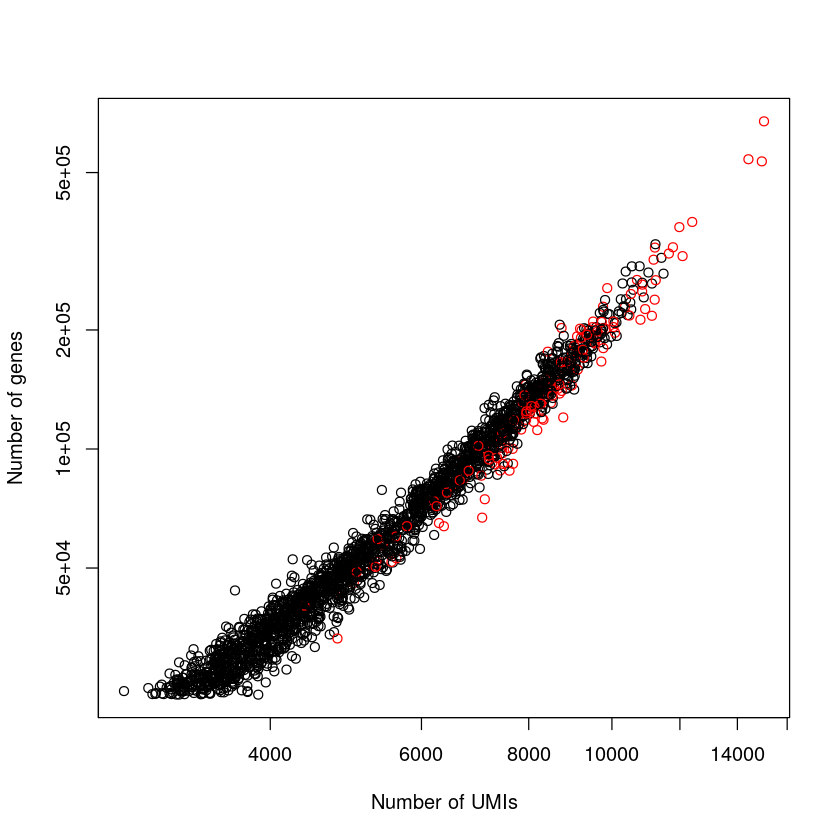

In [35]:
#selected doublets should have higher number of UMIs and genes
plot(putamen_raw_umi_droplet_counts[putamen_called]~putamen_raw_gene_droplet_counts[putamen_called],col=ifelse(sce_putamen$hybrid_score>1.0,"red","black"),log="xy",xlab="Number of UMIs",ylab="Number of genes")

In [36]:
#create annoation matrix for putamen and write to file
putamen_annotation =  data.frame("cell_id"=putamen_1@colData@listData$Barcode[putamen_called],
                                 "nUMIs"=putamen_raw_umi_droplet_counts[putamen_called]-1,
                                 "nGenes"=putamen_raw_gene_droplet_counts[putamen_called]-1,
                                 "doublet_score"=colData(sce_putamen)$hybrid_score)
putamen_annotation$region = rep("putamen",nrow(putamen_annotation))

In [37]:
putamen_annotation_file = "../data/processed/putamen_cells_annotation.csv"
write.csv(putamen_annotation,putamen_annotation_file)

In [38]:
#write putamen cells expression matrix to file 
putamen_df = as.data.frame(as.matrix(putamen_cells))
colnames(putamen_df)<- putamen_1@colData@listData$Barcode[putamen_called]
putamen_path = "../data/processed/putamen_cells.feather"
write_feather(putamen_df,putamen_path)

In [39]:
#now we repeat the same process with the nacc
#read in srna-seq matrix files, these folders should have a barcodes.tsv, genes.tsv, and matrix.mtx files
#For a star-solo based alignment we read in the lanes seperately and the combine them
#For Cell Ranger based alignment we can just read in the filtered matrices
nacc_1 <- read10xCounts("../data/raw/nacc/L1/Solo.out/")
nacc_2 <- read10xCounts("../data/raw/nacc/L2/Solo.out/")
nacc_3 <- read10xCounts("../data/raw/nacc/L3/Solo.out/")
nacc_4 <- read10xCounts("../data/raw/nacc/L4/Solo.out/")

In [40]:
#combine lanes for the nacc, you ran cell ranger
nacc_all <- counts(nacc_1)+counts(nacc_2)+counts(nacc_3)+counts(nacc_4)

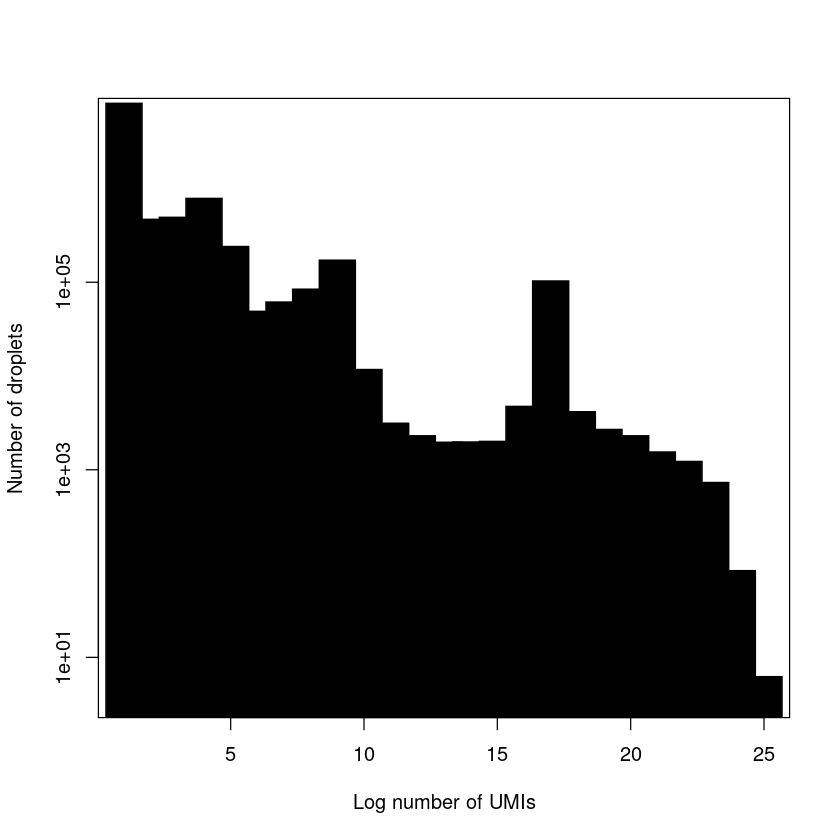

In [41]:
#plot number of umis per droplet
#add pseudocount of 1 for log transform
nacc_raw_umi_droplet_counts = colSums(nacc_all)+1
nacc_raw_droplet_umi_hist = hist(log(nacc_raw_umi_droplet_counts),plot=FALSE,breaks=20) 
plot(nacc_raw_droplet_umi_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of UMIs",ylab="Number of droplets")


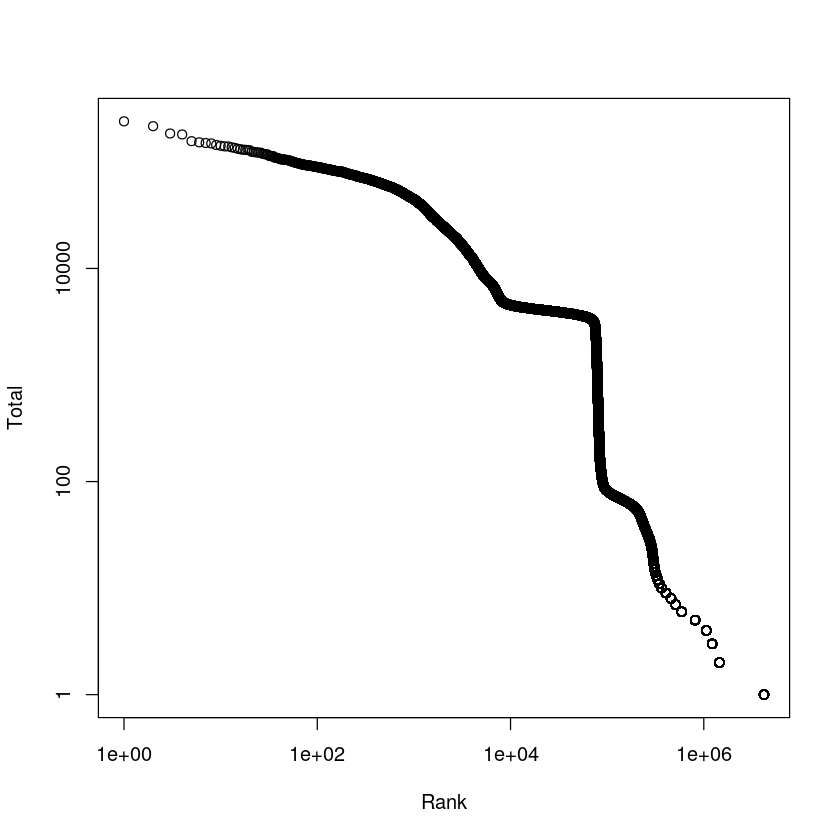

In [42]:
#plotting number of umis vs the rank
nacc_br_out = barcodeRanks(nacc_all)
plot(nacc_br_out$rank, nacc_br_out$total+1, log="xy", xlab="Rank", ylab="Total")


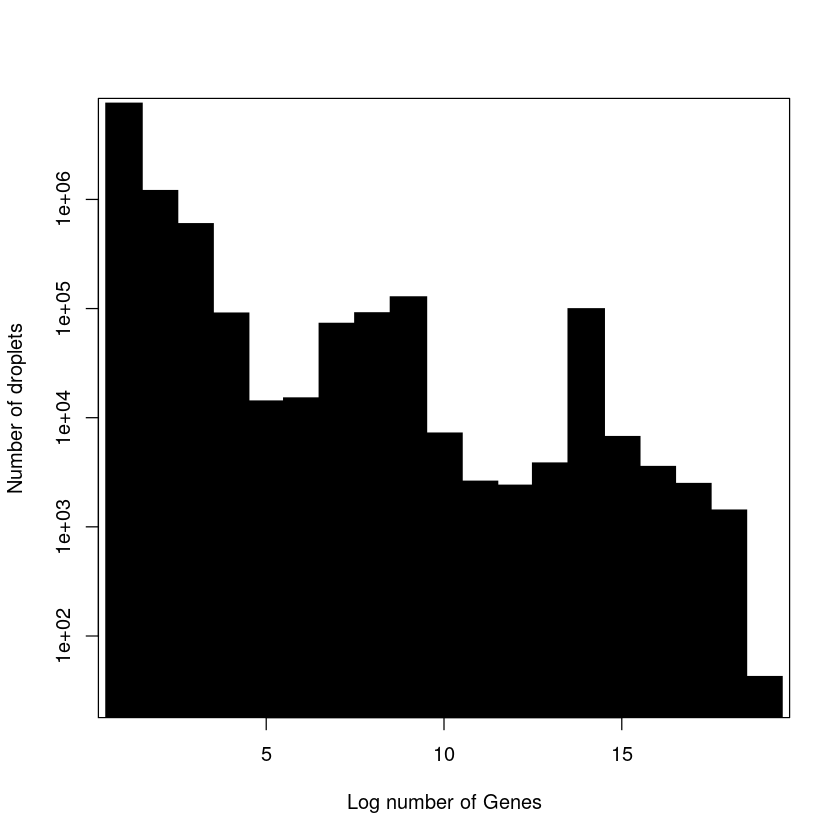

In [43]:
#plot number of umis per droplet
#binarizing the matrix with >0 turns UMI counts into gene counts
nacc_raw_gene_droplet_counts = colSums(nacc_all>0)+1
nacc_raw_droplet_gene_hist = hist(log(nacc_raw_gene_droplet_counts),plot=FALSE,breaks=20) 
plot(nacc_raw_droplet_gene_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of Genes",ylab="Number of droplets")

In [ ]:
#plotting number of UMIs vs number of genes
plot(nacc_raw_umi_droplet_counts~nacc_raw_gene_droplet_counts,log="xy",xlab="Number of UMIs",ylab="Number of genes")


In [ ]:
#predict which droplets are empty, the defaultdrops functin replciates the same task in cell ranger
nacc_called <- defaultDrops(nacc_all)

In [ ]:
#plot which droplets got picked as cells
plot(nacc_raw_umi_droplet_counts~nacc_raw_gene_droplet_counts,col=ifelse(nacc_called,"red","black"),log="xy",xlab="Number of UMIs",ylab="Number of genes")


In [ ]:
#plot which droplets got picked as cells in the rank plot
plot(nacc_br_out$rank, nacc_br_out$total+1, col=ifelse(nacc_called,"red","black"),log="xy", xlab="Rank", ylab="Total")

In [ ]:
#plot number of umis per cell
nacc_called_droplet_umi_hist = hist(log(nacc_raw_umi_droplet_counts[nacc_called]),plot=FALSE,breaks=30) 
plot(nacc_called_droplet_umi_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of UMIs",ylab="Number of Cells")


In [ ]:
#plot number of genes per droplet
nacc_raw_droplet_gene_hist = hist(log(nacc_raw_gene_droplet_counts[nacc_called]),plot=FALSE,breaks=30) 
plot(nacc_raw_droplet_gene_hist$count, log="y", type='h', lwd=30, lend=2,xlab="Log number of Genes",ylab="Number of droplets")

In [ ]:
#plotting number of UMIs vs number of genes for called cells
plot(nacc_raw_umi_droplet_counts[nacc_called]~nacc_raw_gene_droplet_counts[nacc_called],log="xy",xlab="Number of UMIs",ylab="Number of genes")

In [ ]:
#remove empty droplets and create a SingleCellExperiment object
nacc_cells <- nacc_all[, nacc_called]
sce_nacc <- SingleCellExperiment(list(counts=nacc_cells))
rowData(sce_nacc) = rowData(nacc_1)

In [ ]:
#use the scds package to remove doublets
sce_nacc <- cxds_bcds_hybrid(sce_nac,list("retRes"=TRUE))


In [ ]:
#selected doublets should have higher number of UMIs and genes
plot(nacc_raw_umi_droplet_counts[nacc_called]~nacc_raw_gene_droplet_counts[nacc_called],col=ifelse(sce_nacc$hybrid_score>1.0,"red","black"),log="xy",xlab="Number of UMIs",ylab="Number of genes")


In [ ]:
#create annoation matrix for nacc and write to file
nacc_annotation =  data.frame("cell_id"=nacc_1@colData@listData$Barcode[nacc_called],
                                 "nUMIs"=nacc_raw_umi_droplet_counts[nacc_called]-1,
                                 "nGenes"=nacc_raw_gene_droplet_counts[nacc_called]-1,
                                 "doublet_score"=colData(sce_nacc)$hybrid_score)
nacc_annotation$region = rep("nacc",nrow(nacc_annotation))

nacc_annotation_file = "../data/processed/nacc_cells_annotation.csv"
write.csv(nacc_annotation,nacc_annotation_file)

In [ ]:
#write nacc cells expression matrix to file 
nacc_df = as.data.frame(as.matrix(nacc_cells))
colnames(nacc_df)<- nacc_1@colData@listData$Barcode[nacc_called]
nacc_path = "../data/processed/nacc_cells.feather"
write_feather(nacc_df,nacc_path)